https://huggingface.co/learn/computer-vision-course/en/unit3/vision-transformers/vision-transformer-for-objection-detection

Transform data into following structure

```python
DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'width', 'height', 'objects'],
        num_rows: 5297
    })
    test: Dataset({
        features: ['image', 'image_id', 'width', 'height', 'objects'],
        num_rows: 1766
    })
})
```


In [1]:
from datasets import Dataset, DatasetDict
from PIL import Image
import json
import os
import supervision as sv
from transformers import AutoImageProcessor

In [2]:
def sv_to_custom_format(sv_dataset, class_mapping=None):
    images = []
    image_ids = []
    widths = []
    heights = []
    objects = []
        
    image_id = 0
    for path, image, detections in sv_dataset:
        # Load image
        img = Image.open(path)
        images.append(img)
        image_ids.append(image_id)
        width, height = (416, 416)
        widths.append(width)
        heights.append(height)
        
        # Process detections
        object_ids = []
        bboxes = []
        areas = []
        categories = []

        for detection in detections:
            x_min, y_min, x_max, y_max = detection[0]  # Supervision bounding box
            bbox = [x_min, y_min, x_max - x_min, y_max - y_min]
            area = (x_max - x_min) * (y_max - y_min)  # Compute area
            category = class_mapping[detection[3]] if class_mapping else str(detection[3])
            object_ids.append(detection[3])

            bboxes.append(bbox)
            areas.append(area)
            categories.append(category)

        objects.append({
            "id": object_ids,
            "bbox": bboxes,
            "area": areas,
            "category": categories
        })
        
        image_id += 1

    formatted_data = {
        "image": images,
        "image_id": image_ids,
        "width": widths,
        "height": heights,
        "objects": objects
    }
    return formatted_data

In [3]:
def get_class_mappings_from_coco(annotation_path):
    """
    Extracts class mappings from a COCO annotations file.
    
    Args:
        annotation_path (str): Path to the COCO annotations JSON file.
        
    Returns:
        dict: Mapping from class IDs to class names.
    """
    with open(annotation_path, "r") as f:
        coco_data = json.load(f)
    
    # Extract categories
    categories = coco_data["categories"]
    class_mapping = {category["id"]: category["name"] for category in categories}
    return class_mapping

In [4]:
ds_path = r"C:\Users\isaac\dev\CV_Garbage_Detection\Data"

ds_train = sv.DetectionDataset.from_coco(
    images_directory_path=os.path.join(ds_path, "train"),
    annotations_path=os.path.join(ds_path, "train", "_annotations.coco.json"),
)

ds_test = sv.DetectionDataset.from_coco(
    images_directory_path=os.path.join(ds_path, "test"),
    annotations_path=os.path.join(ds_path, "test", "_annotations.coco.json"),
)

ds_valid = sv.DetectionDataset.from_coco(
    images_directory_path=os.path.join(ds_path, "valid"),
    annotations_path=os.path.join(ds_path, "valid", "_annotations.coco.json"),
)

In [5]:
class_mappings = get_class_mappings_from_coco(os.path.join(ds_path, "train", "_annotations.coco.json"))

formatted_train = sv_to_custom_format(ds_train, class_mappings)
formatted_test = sv_to_custom_format(ds_test, class_mappings)
formatted_valid = sv_to_custom_format(ds_valid, class_mappings)

In [6]:
train_dataset = Dataset.from_dict(formatted_train)
test_dataset = Dataset.from_dict(formatted_test)
valid_dataset = Dataset.from_dict(formatted_valid)

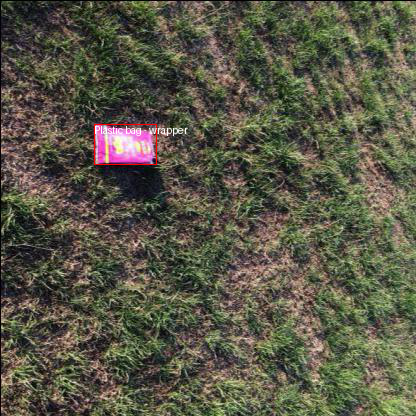

In [7]:
import numpy as np
from PIL import Image, ImageDraw


def draw_image_from_idx(dataset, idx):
    sample = dataset[idx]
    image = sample["image"]
    annotations = sample["objects"]
    draw = ImageDraw.Draw(image)
    width, height = sample["width"], sample["height"]

    for i in range(len(annotations["id"])):
        box = annotations["bbox"][i]
        class_idx = annotations["id"][i]
        x, y, w, h = tuple(box)
        if max(box) > 1.0:
            x1, y1 = int(x), int(y)
            x2, y2 = int(x + w), int(y + h)
        else:
            x1 = int(x * width)
            y1 = int(y * height)
            x2 = int((x + w) * width)
            y2 = int((y + h) * height)
        draw.rectangle((x1, y1, x2, y2), outline="red", width=1)
        draw.text((x1, y1), annotations["category"][i], fill="white")
    return image


draw_image_from_idx(dataset=train_dataset, idx=1)

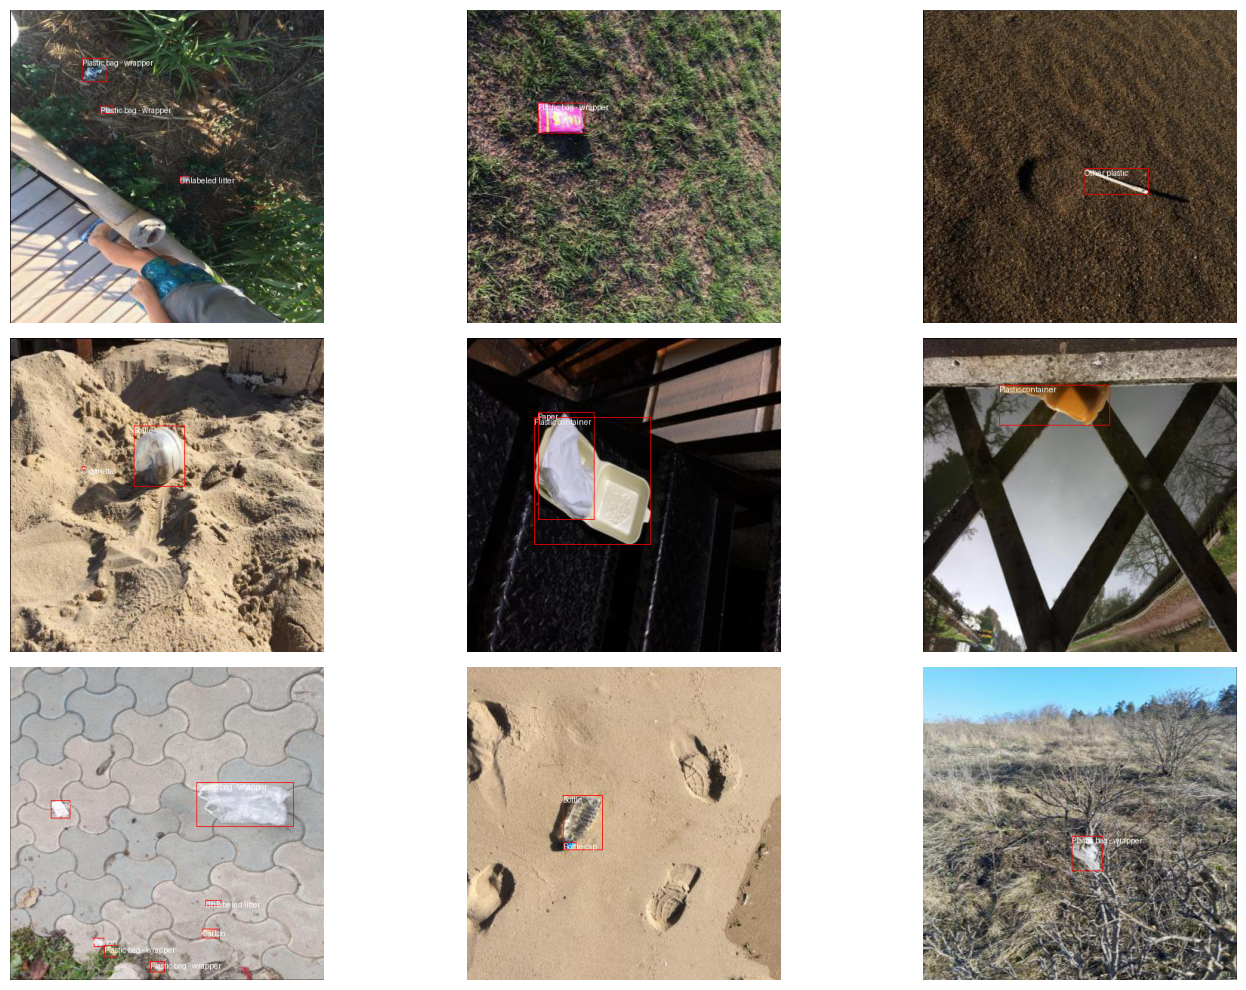

In [8]:
import matplotlib.pyplot as plt


def plot_images(dataset, indices):
    """
    Plot images and their annotations.
    """
    num_rows = len(indices) // 3
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i, idx in enumerate(indices):
        row = i // num_cols
        col = i % num_cols

        # Draw image
        image = draw_image_from_idx(dataset, idx)

        # Display image on the corresponding subplot
        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()


# Now use the function to plot images

plot_images(train_dataset, range(9))

In [9]:
from transformers import AutoImageProcessor

checkpoint = "microsoft/conditional-detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [10]:
import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [11]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [12]:
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["id"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [13]:
train_dataset_transformed = train_dataset.with_transform(transform_aug_ann)
test_dataset_transformed = test_dataset.with_transform(transform_aug_ann)
train_dataset_transformed[0]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


{'pixel_values': tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -1.7754, -1.9980, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -1.1247, -1.7754, -2.1179],
          ...,
          [-1.6384, -1.6384, -1.6384,  ..., -0.3712, -1.5185, -2.1179],
          [-1.6555, -1.6555, -1.6555,  ..., -0.7308, -1.6213, -2.1179],
          [-1.6727, -1.6727, -1.6555,  ..., -0.9192, -1.6898, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -1.6856, -1.9132, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -1.0203, -1.6856, -2.0357],
          ...,
          [-1.0728, -1.0728, -1.0728,  ..., -0.1625, -1.3880, -2.0357],
          [-1.0903, -1.0903, -1.0903,  ..., -0.5126, -1.4930, -2.0357],
          [-1.1078, -1.1078, -1.0903,  ..., -0.7052, -1.5630, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-

In [14]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [15]:
from transformers import AutoModelForObjectDetection

label2id = {v: k for k, v in class_mappings.items()}
id2label = {k: v for k, v in class_mappings.items()}


model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of ConditionalDetrForObjectDetection were not initialized from the model checkpoint at microsoft/conditional-detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([19]) in the model instantiated
- class_labels_classifier.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([19, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
from transformers import TrainingArguments
from transformers import Trainer

# Define the training arguments

training_args = TrainingArguments(
    output_dir="conditional-detr-resnet-50-finetuned-v2",
    per_device_train_batch_size=4,
    num_train_epochs=200,
    fp16=True,
    save_steps=10,
    logging_steps=30,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
)

In [17]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_dataset_transformed,
    eval_dataset=test_dataset_transformed,
    tokenizer=image_processor,
)

trainer.train()

  0%|          | 0/210000 [00:00<?, ?it/s]

{'loss': 636.8643, 'grad_norm': 1528.3736572265625, 'learning_rate': 9.99904761904762e-06, 'epoch': 0.03}
{'loss': 361.0302, 'grad_norm': 2059.25732421875, 'learning_rate': 9.997619047619048e-06, 'epoch': 0.06}
{'loss': 206.2372, 'grad_norm': 1012.4342651367188, 'learning_rate': 9.996190476190476e-06, 'epoch': 0.09}
{'loss': 109.3164, 'grad_norm': 309.83563232421875, 'learning_rate': 9.994761904761906e-06, 'epoch': 0.11}
{'loss': 88.3502, 'grad_norm': 210.57794189453125, 'learning_rate': 9.993333333333333e-06, 'epoch': 0.14}
{'loss': 59.9661, 'grad_norm': 651.7784423828125, 'learning_rate': 9.991904761904763e-06, 'epoch': 0.17}
{'loss': 51.3251, 'grad_norm': 166.5255584716797, 'learning_rate': 9.990476190476191e-06, 'epoch': 0.2}
{'loss': 47.1371, 'grad_norm': 70.9719009399414, 'learning_rate': 9.98904761904762e-06, 'epoch': 0.23}
{'loss': 37.0104, 'grad_norm': 163.26602172851562, 'learning_rate': 9.987619047619048e-06, 'epoch': 0.26}
{'loss': 30.265, 'grad_norm': 120.62608337402344, '

TrainOutput(global_step=210000, training_loss=0.8374904214813595, metrics={'train_runtime': 71735.9252, 'train_samples_per_second': 11.71, 'train_steps_per_second': 2.927, 'total_flos': 4.1922894504937705e+20, 'train_loss': 0.8374904214813595, 'epoch': 200.0})

In [18]:
trainer.save_model("conditional-detr-resnet-50-finetuned-v2")

evaluate the model

In [73]:
def plot_results(image, results, threshold=0.7):
    image = Image.fromarray(np.uint8(image))
    draw = ImageDraw.Draw(image)
    for result in results:
        score = result["score"]
        label = result["label"]
        box = list(result["box"].values())
        if score > threshold:
            x, y, x2, y2 = tuple(box)
            draw.rectangle((x, y, x2, y2), outline="red", width=1)
            draw.text((x, y), label, fill="white")
            draw.text(
                (x + 0.5, y - 0.5),
                text=str(score),
                fill="green" if score > 0.7 else "red",
            )
    return image

Predicted Results: [{'score': 0.8556180596351624, 'label': 'Can', 'box': {'xmin': 142, 'ymin': 198, 'xmax': 220, 'ymax': 240}}, {'score': 0.7685534954071045, 'label': 'Bottle cap', 'box': {'xmin': 140, 'ymin': 242, 'xmax': 147, 'ymax': 247}}]


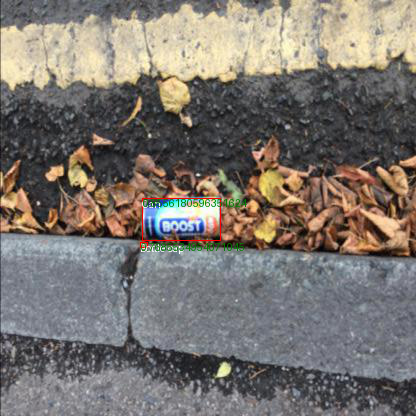

In [77]:
from transformers import pipeline

idx = 2

img = valid_dataset[idx]["image"]
obj = pipeline("object-detection", model="conditional-detr-resnet-50-finetuned-v2", device=0)

tr = 0.5

res = obj(img, threshold=tr)
print("Predicted Results:",res)
plot_results(img, res, threshold=tr)

Ground Truth: {'area': [3504.5], 'bbox': [[142.0, 197.0, 81.5, 43.0]], 'category': ['Can'], 'id': [5]}


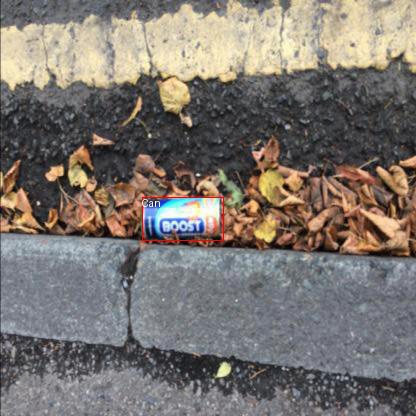

In [78]:
print("Ground Truth:", valid_dataset[idx]["objects"])
draw_image_from_idx(valid_dataset, idx)

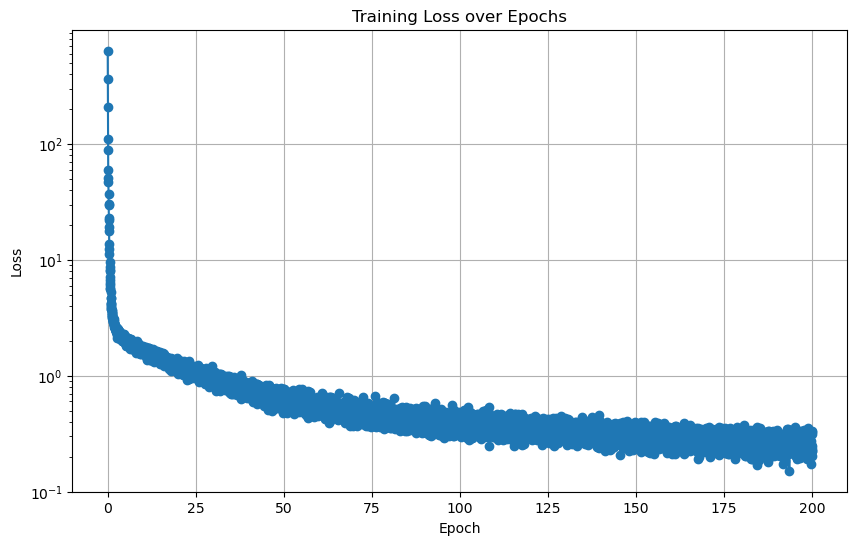

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract loss from log history
log_history = trainer.state.log_history

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(log_history)

# Filter only relevant columns
loss_df = df[["epoch", "loss"]].dropna()

# Group by epoch to compute average loss per epoch
avg_loss_per_epoch = loss_df.groupby("epoch")["loss"].mean()

plt.figure(figsize=(10, 6))
plt.plot(avg_loss_per_epoch.index, avg_loss_per_epoch.values, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.yscale("log")
plt.show()